In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import yfinance as yf
from datetime import date, timedelta

In [59]:
# تحديد عدد الأيام السابقة التي نريد استخدامها لحساب التاريخ البدائي
days = 100
today = date.today()
end_date = today.strftime("%Y-%m-%d")
start_date = today - timedelta(days=days)
start_date = start_date.strftime("%Y-%m-%d")

In [61]:
# جلب البيانات التاريخية لزوج العملات BTC/USD
data = yf.download('EURUSD=X', start=start_date, end=end_date, progress=False)

# إذا كان العمود "Date" موجوداً بالفعل، نعيد تسميته أو نحذفه
if 'Date' in data.columns:
    data.drop(columns=['Date'], inplace=True)  # حذف العمود "Date" إذا كان موجوداً

# إضافة العمود "Date" من الفهرس
data["Date"] = data.index

# إعادة تعيين الفهرس
data.reset_index(drop=True, inplace=True)


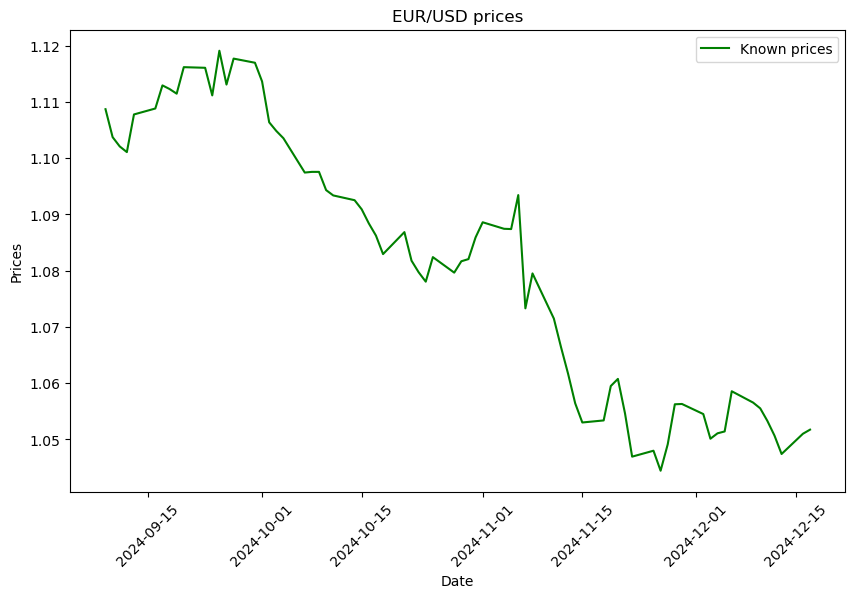

In [63]:
# رسم الأسعار التاريخية
dates = data["Date"]
prices = data["Adj Close"]
plt.figure(figsize=(10, 6))
plt.plot(dates, prices, color='green', label='Known prices')
plt.xlabel("Date")
plt.ylabel("Prices")
plt.title("EUR/USD prices")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [65]:
# دالة لإنشاء مجموعات البيانات
def create_dataset(serie, window_size=20):
    dataX, dataY = [], []
    for i in range(len(serie) - window_size - 1):
        a = serie[i:(i + window_size), 0]
        dataX.append(a)
        dataY.append([serie[i + window_size, 0]])
    return np.array(dataX), np.array(dataY)


In [67]:
# تحديد حجم النافذة وتقييس البيانات
window_size = 20
closedf = data[['Adj Close']]
scaler = MinMaxScaler(feature_range=(0, 1))
closedf = scaler.fit_transform(closedf)
X, y = create_dataset(closedf, window_size)


In [69]:
# تقسيم البيانات إلى مجموعات تدريب واختبار
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


In [71]:
# بناء نموذج LSTM
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Sequential
model = Sequential()
model.add(Input(shape=(window_size, 1)))
model.add(LSTM(units=32, dropout=0.1, activation='relu'))
model.add(Dense(1, activation='relu'))
model.compile(loss="mean_squared_error", optimizer="adam", metrics=['mse'])

In [73]:
# تدريب النموذج
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=10, batch_size=8, verbose=0)

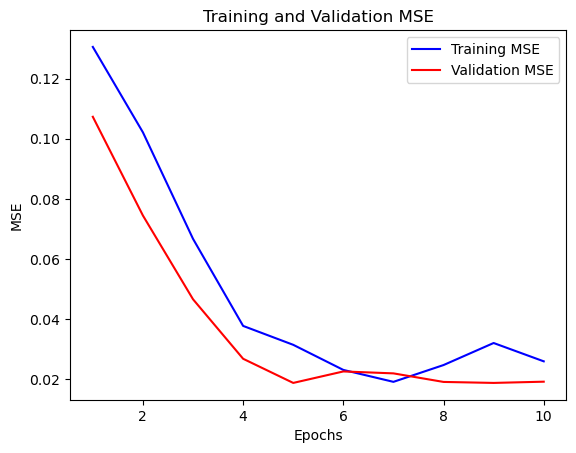

In [74]:
# رسم منحنيات MSE للتدريب والتحقق
train_mse = history.history['mse']
val_mse = history.history['val_mse']
epochs = range(1, len(train_mse) + 1)
plt.plot(epochs, train_mse, 'b', label='Training MSE')
plt.plot(epochs, val_mse, 'r', label='Validation MSE')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

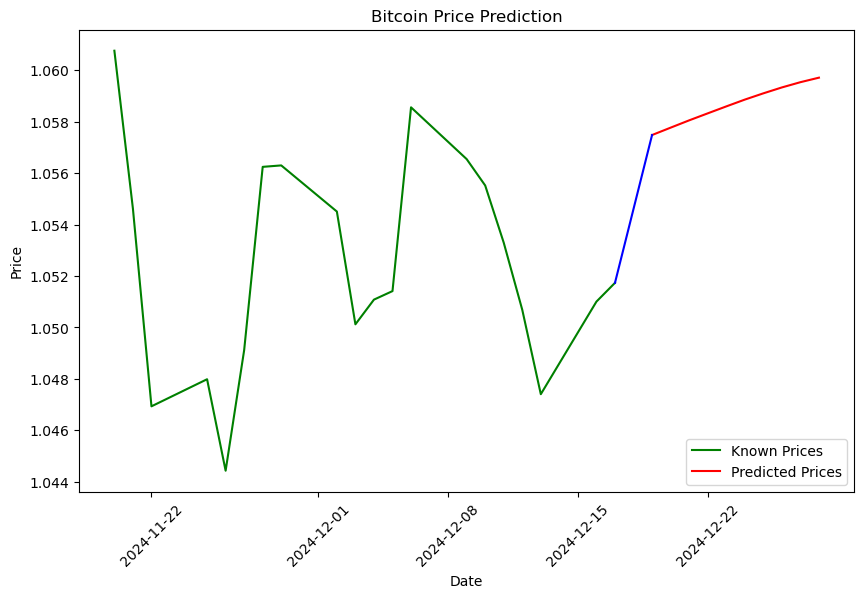

In [93]:
# التنبؤ بالأسعار
pred_steps = 10
predicted_prices = []
X_pred = [X[-1]]
X_pred = np.array(X_pred)
for _ in range(pred_steps):
    prediction = model.predict([X_pred], verbose=0)  # Disable verbose output
    price = prediction[0]
    predicted_prices.append(price)
    X_pred = np.append(X_pred, [price], axis=1)
    X_pred = X_pred[:, 1:]

predicted_prices = np.array(predicted_prices)
predicted_prices = scaler.inverse_transform(predicted_prices)

# رسم التوقعات
previous_days = 20
dates_known = pd.to_datetime(data["Date"].iloc[-previous_days:].values) # تحويل التواريخ إلى datetime
known_prices = data["Adj Close"].iloc[-previous_days:].values
dates_pred = pd.date_range(start=today + timedelta(days=1), periods=pred_steps).normalize() # تحويل التواريخ إلى datetime
plt.figure(figsize=(10, 6))
plt.plot(dates_known, known_prices, color='green', label='Known Prices')
plt.plot(dates_pred, predicted_prices.flatten(), color='red', label='Predicted Prices')
plt.plot([dates_known[-1], dates_pred[0]], [known_prices[-1], predicted_prices[0]], color='blue') # تصحيح استخراج القيمة واستخدام flatten
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bitcoin Price Prediction')
plt.xticks(rotation=45)
plt.legend()
plt.show()